# <font color='darkblue'> THE NETWORK OF BEATLES' SONGS

## <font color='darkblue'>Analysis of the network of Beatles'Songs: Getting into their mind

In [13]:
#We import all the necessary packages we used for this project

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ast
import operator
import powerlaw
from fa2 import ForceAtlas2
import re
from urllib.request import urlopen
import urllib.request as urllib2
import os
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist


###  <font color='darkblue'>Part 1a: Extraction of information from Beatles Official Page.

In [2]:
#We have create a function to obtain the 'HTLM' of Beatles Official Page. 
def extract_html(url):
    page = urlopen(url)
    html_bytes = page.read()
    html = html_bytes.decode("utf-8")
    return html

In [46]:
#We obtain all the list of songs and we stored it in the Variable Songs_Titles
pattern1= 'hreflang="en">(.*?)</a>'
pattern2= 'chronological-date">(.*?)</td>'

songs_titles=[]
song_years=[]

for i in range(0,9): 
    url = 'https://www.thebeatles.com/songs?page='+str(i)
    html=extract_html(url)
    a=re.findall(pattern1,html)
    b=re.findall(pattern2,html)
    
    for el in a:
        el=el.replace('&#039;', '\'')
        songs_titles.append(el)
    
    for el2 in b:
        song_years.append(el2)

print('The official Beatles page contains information of a number of' , len(songs_titles), 'songs.')

The official Beatles page contains information of a number of 301 songs.


In [49]:
data={'song':songs_titles,'year':song_years}
df=pd.DataFrame(data)
df

,song,year
0,12-Bar Original,"Monday, 18th March, 1996"
1,1822!,"Wednesday, 30th November, 1994"
2,A Beginning,"Monday, 28th October, 1996"
3,A Day In The Life,"Thursday, 1st June, 1967"
4,A Hard Day's Night,"Friday, 10th July, 1964"
...,...,...
296,You'll Be Mine,"Monday, 20th November, 1995"
297,You're Going To Lose That Girl,"Friday, 6th August, 1965"
298,You've Got To Hide Your Love Away,"Friday, 6th August, 1965"
299,Young Blood,"Wednesday, 30th November, 1994"


<font color='darkblue'>Next, we obtain the **url link** to download the lyrics of each song and we saved the extracted text in a .txt file

In [5]:
remove_list=[' a ',' in ',' the ',' of ',' to ',' is ',' at ',' for ',' that ',' by ',' as ',' from ',' into ',
             ' on ',' with ',' off ',' this ',' up ',' like ']
remove_list_start=['a-','in-','the-','of-','to-','is-','at-','for-','that-','by-','as-','from-','like-','this-',
                  'with-']
remove_list_end=['-by','-to','-on','-is','-that','-before']
remove_list2=['\'','.','!','(',')',',','/',':']

pattern6='<div class="col-md-6 middle-content border-left border-right"><p>'
pattern7='<figure class="wp-block-table table-expander table table-imported">'
for title in songs_titles:
    try:
        title=title.lower()
        for el in remove_list2: # delete special characters
            title=title.replace(el,'')
        for el in remove_list: # replace single words with a space
            title=title.replace(el,' ')
        title=title.replace(' ','-')
        title=title.replace('--','-')
        # delete words from the start
        for i in range(0,6):
            if title[:i] in remove_list_start:
                title=title[i:]
        # delete words end
        for i in range(0,8):
            if title[-i:] in remove_list_end:
                title=title[:-i]
        if title[0]=='-':
            title=title[1:]
        url='https://www.thebeatles.com/'
        query=extract_html(url+title)
        # write the extracted text in a .txt file
        file=open('raw_songs/'+title+'.txt','w+')
        file.write(query)
        file.close()
    except:
        print(title) #To know the songs where the url could not be obtained. 

words-love


<font color='darkblue'>Sometimes, the page of the song has a number at the end, being a 0 or 1. This is the case of words-love-0. 

In [6]:
pattern6='<div class="col-md-6 middle-content border-left border-right"><p>'
pattern7='<figure class="wp-block-table table-expander table table-imported">'
remove_list=['<br />','\n','</p>','<p>']

def extract_lyrics(song_path):
    song=open(song_path).read()
    idx_init = re.search(pattern6,song).end()
    idx_final = re.search(pattern7,song).start()
    lyrics=song[idx_init:idx_final]
    for el in remove_list: # delete special characters
        lyrics=lyrics.replace(el,' ')
    return lyrics

<font color='darkblue'>Then, we extract the lyrics of each songs specifying the patterns. Provided that the song has no lyrics, we classified it as an instrumental song and will not be part of our network. 

In [20]:
txt_files = os.listdir('raw_songs')
songs_no_lyrics=[]
for el in txt_files:
    el=el[:-4]
    song_path='raw_songs/'+el+'.txt'
    try:
        lyrics=extract_lyrics(song_path)
        file=open('lyrics_songs/'+el+'.txt','w+')
        file.write(lyrics)
        file.close()
    except:
        songs_no_lyrics.append(el)


In [21]:
lyrics_files = os.listdir('lyrics_songs')
for el in songs_no_lyrics:
    el=el[:-4]
    url='https://www.thebeatles.com/'
    # check if the song has lyrics or not
    for i in range(0,4):
        try:
            query=extract_html(url+el+'-'+str(i))
            idx_init = re.search(pattern6,query).end()
            idx_final = re.search(pattern7,query).start()
            # rewrite the extracted text in a .txt file
            file=open('raw_songs/'+el+'.txt','w+')
            file.write(query)
            file.close()
            print(el, i)
            break
        except:
            pass

In [23]:
print('The official Beatles page contains' , len(lyrics_files)+len(songs_no_lyrics), 'Songs, with',len(lyrics_files),
     'Lyrics Songs and',len(songs_no_lyrics),'Instrumental ones. ') 

The official Beatles page contains 301 Songs, with 197 Lyrics Songs and 104 Instrumental ones. 


###  <font color='darkblue'>Part 1b: Extraction of information from Beatles Wikipages of Songs.

###  <font color='darkblue'>Part 2: Clean Lyrics of Songs.

In [24]:
stop_words = list(set(stopwords.words('english')))
stop_words = [el.replace('\'','') for el in stop_words]
stop_words.append('im')

<font color='darkblue'> A function to **clean the lyrics** is built.

In [30]:
def clean_lyrics(file_path):
    data=open(file_path).read()
    # import WordPunctTokenizer() method from nltk
    # Create a reference variable for Class WordPunctTokenizer
    tk = WordPunctTokenizer()
    # define punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    # remove punctuation from the string
    no_punct = ""
    for char in data:
        if char not in punctuations:
            no_punct = no_punct + char
    # Remove all the special characters as \n and single = left
    char=['\n','=']
    for el in char:
        raw=re.sub(el,'',no_punct)
    # remove stop words
    token_txt = tk.tokenize(raw.lower()) # set to lower case
    token_txt = tk.tokenize(raw.lower()) # set to lower case
    token_final = [x for x in token_txt if x not in stop_words and len(x)>2]
    return token_final

In [28]:
lyrics_files=[el[:-4] for el in os.listdir('lyrics_songs')]
lyrics_files.remove('.DS_S') # remove this element that is introduced when using os.listdir

###  <font color='darkblue'>Part 3: Build the Network.

In [33]:
#After cleaning the lyrics of songs, we found the first five most common words in each song. 
#d_top5 is a dictionary with the most common words used for each song. 
d_top5={}
for file in lyrics_files:
    path='lyrics_songs/'+file+'.txt'
    clean=clean_lyrics(path)
    
    top5=[]
    for el in FreqDist(clean).most_common(5):
        top5.append(el[0])
    d_top5[file]=top5

In [34]:
hyperlinks={} #dictionary to store links 
for file1 in lyrics_files:
    eq_files=[]
    for file2 in lyrics_files:
        if file1!=file2:
            a=d_top5[file1]
            b=d_top5[file2]
            # compute if there are equal words in both lists
            eq=0
            for el in a:
                if el in b:
                    eq+=1
            if eq!=0:
                eq_files.append(file2)
    hyperlinks[file1]=eq_files

<font color='darkblue'> With the links stored, we are able to build the directed Graph based on the date release of the corresponding songs. 

In [41]:
#We build the Directed Network
Beatles_nw= nx.DiGraph()
for file in lyrics_files:
    #We add the nodes and attributes to the the network
    Beatles_nw.add_node(file)

#We add the hyperlinks to the the network
for el in lyrics_files:
    links= hyperlinks[el]
    for a in links:
        u= el
        v= a
        Beatles_nw.add_edge(u,v)

<font color='darkblue'> Next, we extract the **GCC** subgraph of the Beatles network.

In [42]:
Gs = list(Beatles_nw.subgraph(c).copy() for c in nx.weakly_connected_components(Beatles_nw))
biggest = 0
GCC_index = 0
for index,graph in enumerate(Gs):
    if len(graph.nodes) > biggest:
        biggest = len(graph.nodes)
        GCC_index = index
GCC = Gs[GCC_index]

In [44]:
print('- Considering the GCC of the Beatles Network, it has',len(GCC.nodes()),'number of nodes and',
      len(GCC.edges.data()),'number of links.')

- Considering the GCC of the Beatles Network, it has 194 number of nodes and 5230 number of links.


###  <font color='darkblue'>Part 4: Visualize the Network.

In [72]:
# Determing node size depending on the degree of each node. 
degree=[el *20 for el in list(dict(GCC.out_degree()).values())]


#Specifying Labels
highest_degree = dict(sorted(GCC.out_degree, key=lambda x: x[1], reverse=True)[0:20])
labels_draw = list(highest_degree.keys())
labels = {}    
for node in GCC.nodes():
    if node in labels_draw:
        labels[node] = node
        

In [67]:
#Get node positions based on the Force Atlas 2 algorithm 
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.01,#1
                        strongGravityMode=True,#False
                        gravity=1.5, #1.0

                        # Log
                        verbose=False) #True

#getting node positions
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=300)





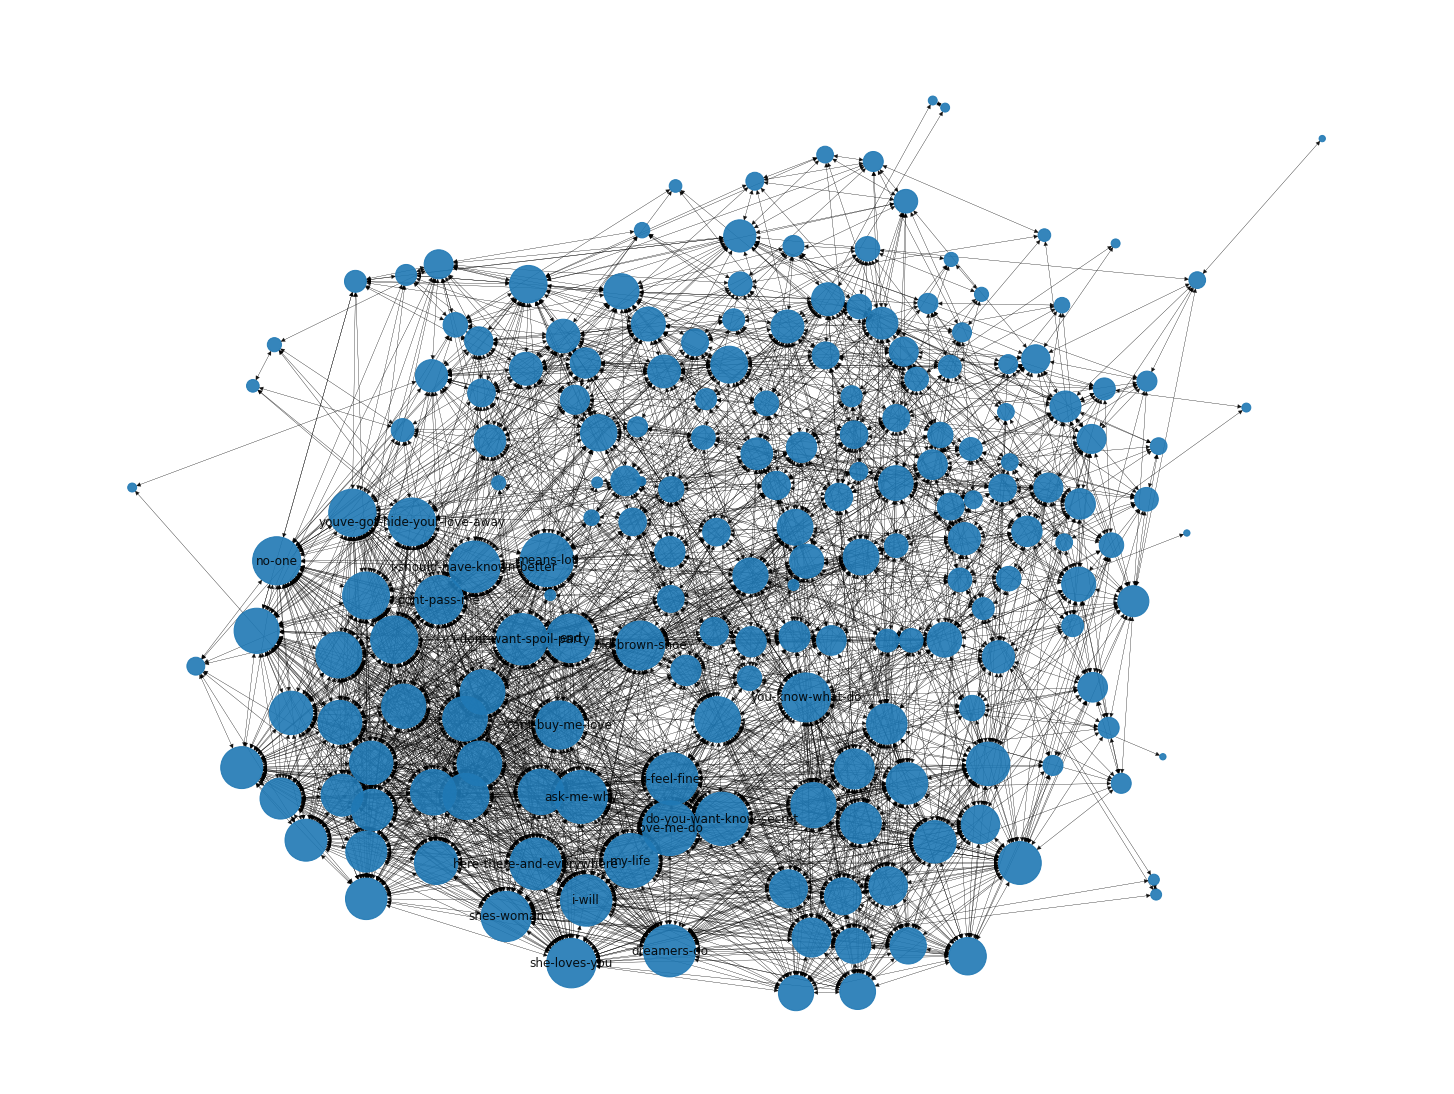

In [71]:
#VISUALIZATION
options = {
    'node_size': out_degree,
    'width': 0.2,
    #'edge_color':edge_colors,
    #'node_color': node_colors
    'labels':labels,
    'alpha':0.9  
}

fig = plt.gcf()
nx.draw(GCC, positions,**options) 
fig.set_size_inches(20, 15)
plt.show()

